In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from lib.nb_08d import *

- [Going deeper with convolutions](https://arxiv.org/pdf/1409.4842.pdf)
- [mixup: BEYOND EMPIRICAL RISK MINIMIZATION](https://arxiv.org/pdf/1710.09412.pdf)
- [Bag of Tricks for Image Classification with Convolutional Neural Networks](https://arxiv.org/abs/1812.01187)

### Data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
size = 128
tfms = [MakeRGB(), RandomResizedCrop(size, scale=(0.35,1)), np_to_float, PilRandomFlip()]

bs = 64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

ll.valid.x.tfms = [MakeRGB(), CenterCrop(size), np_to_float]

data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=8)

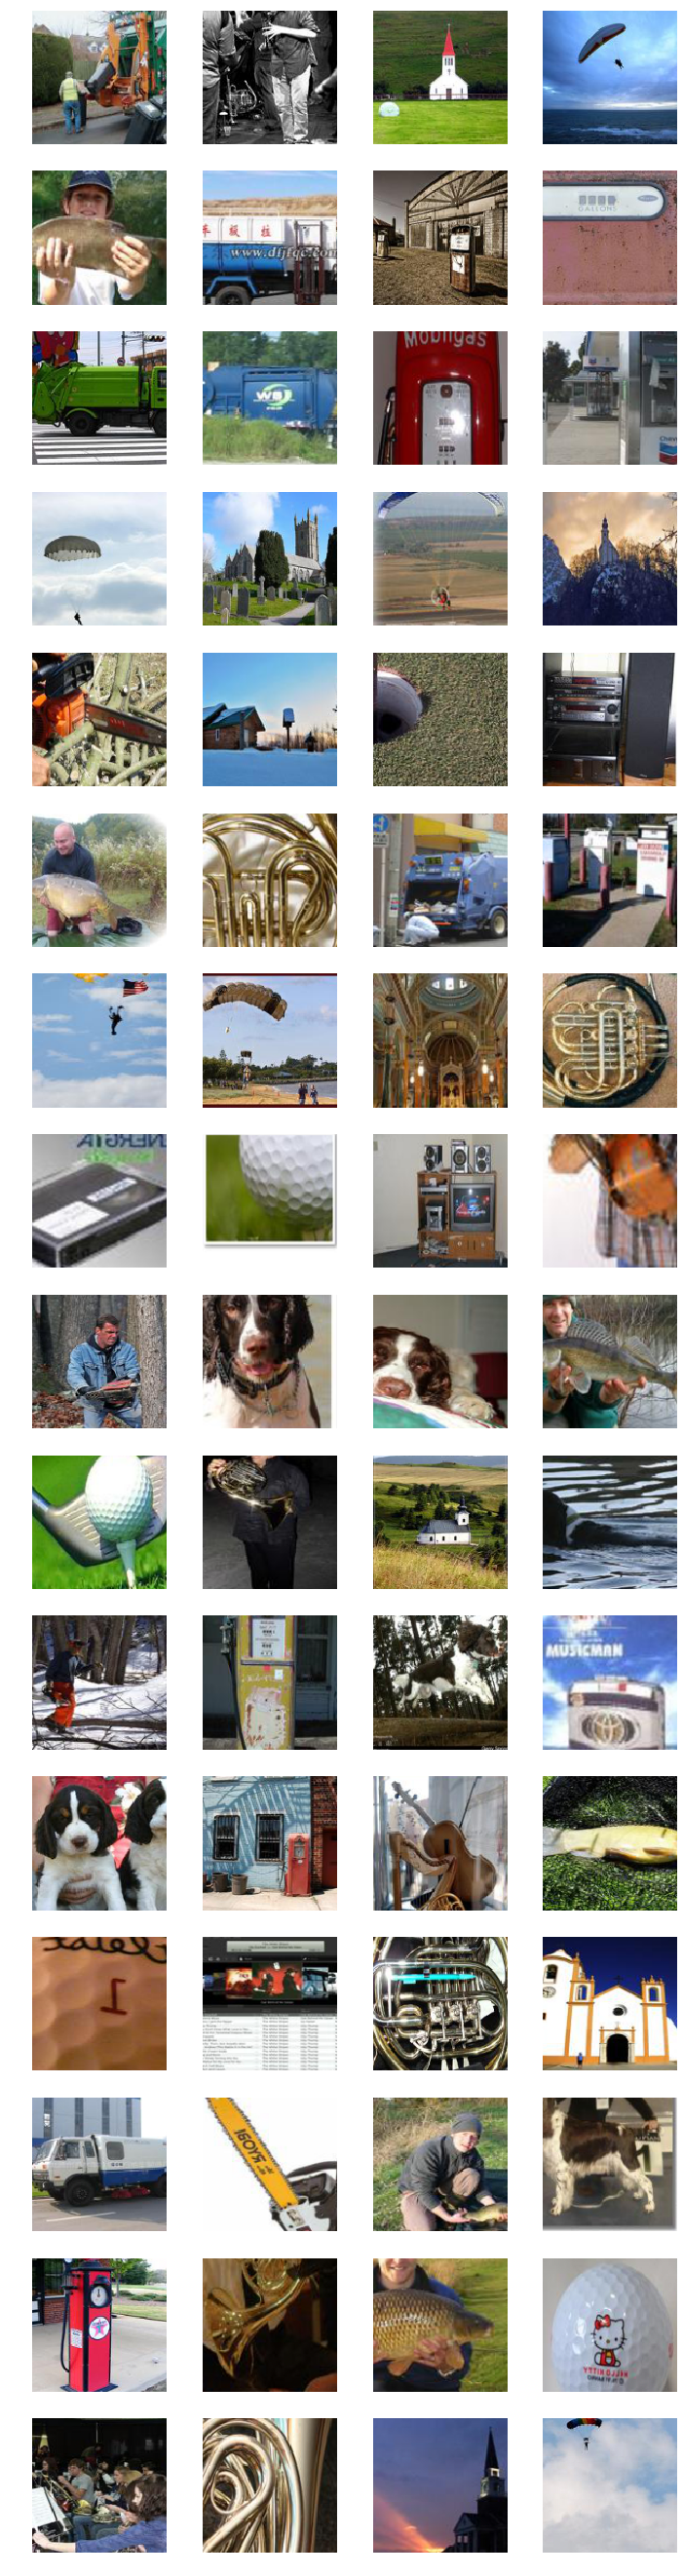

In [5]:
show_batch(next(iter(data.train_dl))[0])

In [6]:
x, y = next(iter(data.train_dl))

In [7]:
y

tensor([5, 7, 9, 4, 3, 4, 8, 8, 4, 7, 1, 8, 0, 6, 5, 5, 7, 0, 7, 9, 5, 2, 8, 8,
        1, 1, 2, 2, 6, 2, 9, 0, 9, 0, 3, 9, 6, 1, 2, 3, 3, 7, 1, 5, 2, 5, 4, 7,
        3, 5, 9, 3, 1, 4, 3, 7, 8, 1, 1, 8, 2, 6, 0, 4])

In [8]:
data.train_ds.proc_y.deproc1(y[0])

'n03888257'

In [9]:
1

1

In [10]:
def show_batch_with_labels(x, y, data, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,yi,ax in zip(x, y, axes.flat): 
        show_image(xi, ax)
        ax.set_title(f"{data.train_ds.proc_y.deproc1(yi)}")

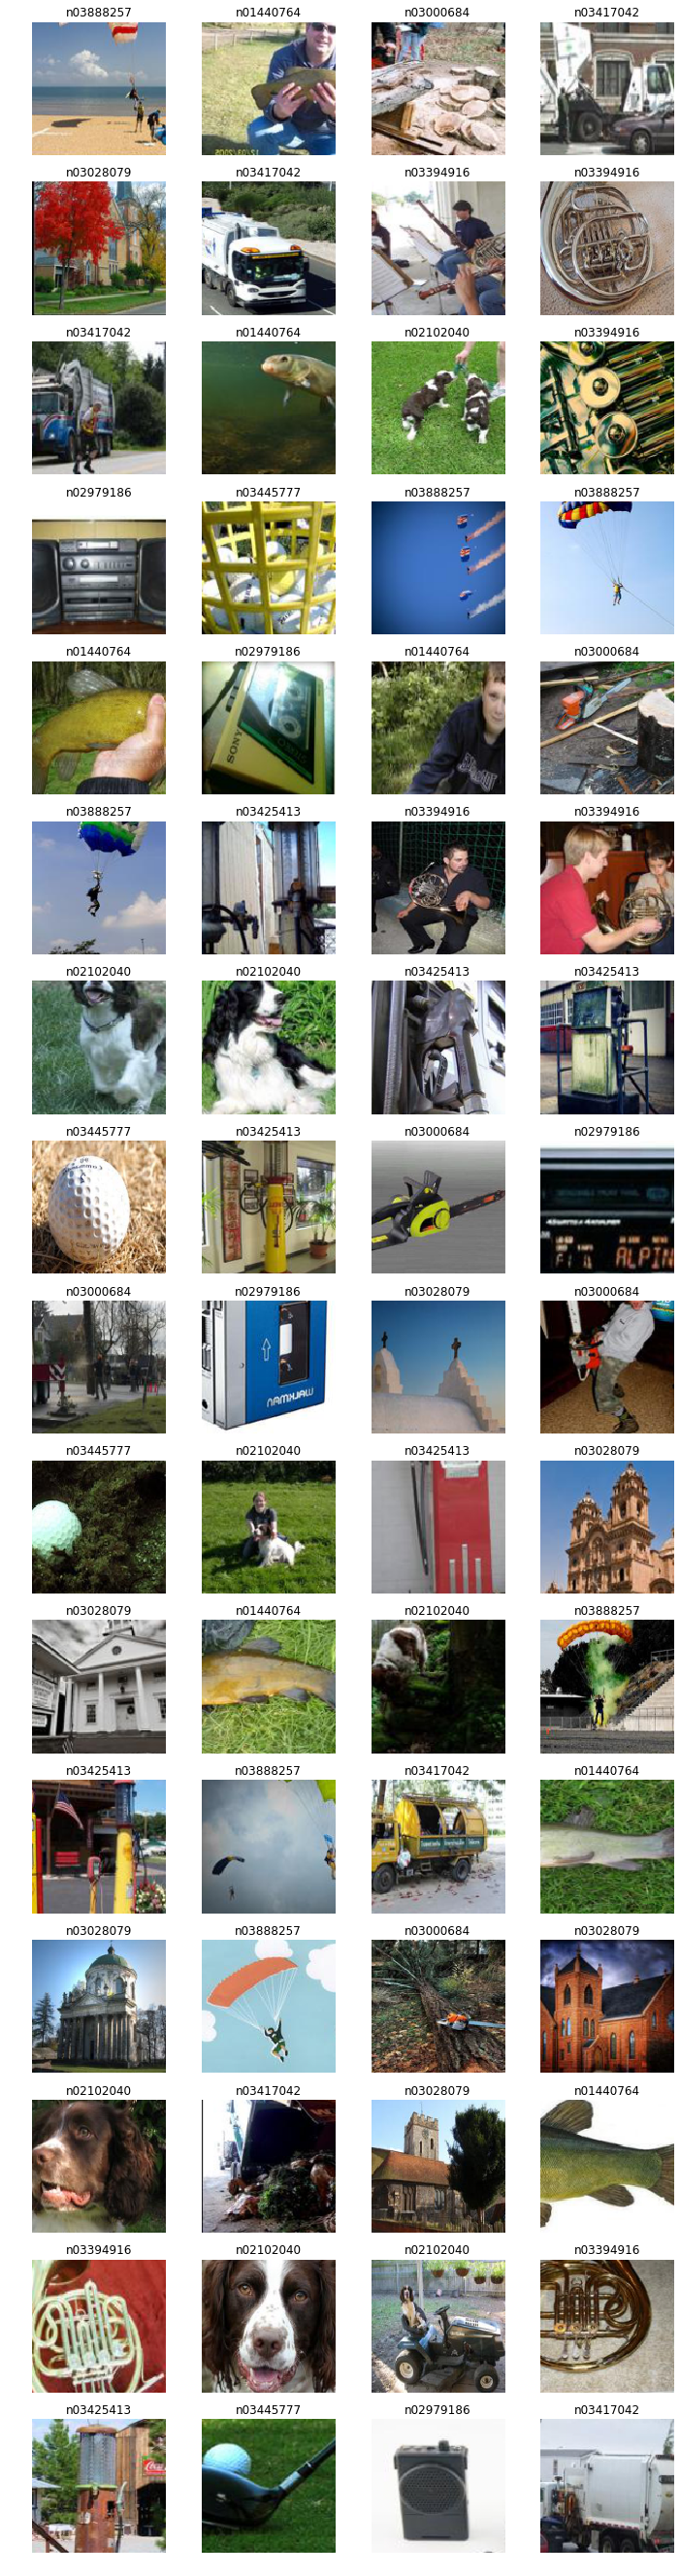

In [11]:
show_batch_with_labels(x,y,data)

### XResNet: Model Tweaks

A model tweak is a minor adjustment to the network architecture, such as changing the stride of a particular convolution layer. Such a tweak often barely changes the computational complexity but might have a non-negligible effect on the model accuracy.

In [12]:
#export
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [13]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

**Typical Resnet-50 Architecture**

<img src="./images/Resnet_orig.PNG" alt="Resnet" width="450" height="150" />

Resnet modifications proposed in the paper

<img src="./images/resnet_mods.PNG" alt="Resnet" width="450" height="150" />

In [14]:
class ResBlock(nn.Module):
    
    def __init__(self,expansion,ni,nh,stride=1):
        super().__init__()
        nf,ni = nh*expansion, ni*expansion
        
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        
    def forward(self,x):
        return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [15]:
torch

<module 'torch' from '/home/paperspace/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/__init__.py'>

In [16]:
inp=torch.ones(size=(128, 10, 64,64))

In [17]:
inp.shape

torch.Size([128, 10, 64, 64])

In [18]:
m = ResBlock(1, 10,10)

In [19]:
m

ResBlock(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)

In [20]:
m(inp).shape

torch.Size([128, 10, 64, 64])

In [21]:
m(inp).shape == inp.shape

True

In [22]:
#export
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [23]:
#export
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [24]:
loss_func = LabelSmoothingCrossEntropy()
arch = partial(xresnet18, c_out=10)
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [25]:
cbfs = [partial(AvgStatsCallback,accuracy), ProgressCallback, partial(CudaCallback, get_device()),
        partial(BatchTransformXCallback, norm_imagenette),
#         partial(MixUp, alpha=0.2)
       ]

In [26]:
#export
def get_batch(dl, learn):
    learn.xb,learn.yb = next(iter(dl))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb,learn.yb

In [27]:
# export
def model_summary(model, data, find_all=False, print_mod=False):
    xb,yb = get_batch(data.valid_dl, learn)
    mods = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook,mod,inp,out: print(f"====\n{mod}\n" if print_mod else "", out.shape)
    with Hooks(mods, f) as hooks: learn.model(xb)

In [28]:
learn = Learner(arch(), data, loss_func, lr=1, cb_funcs=cbfs, opt_func=opt_func)

In [29]:
learn.model = learn.model
model_summary(learn.model, data, print_mod=False)

 torch.Size([128, 32, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 128, 16, 16])
 torch.Size([128, 256, 8, 8])
 torch.Size([128, 512, 4, 4])
 torch.Size([128, 512, 1, 1])
 torch.Size([128, 512])
 torch.Size([128, 10])


In [30]:
learn.model = learn.model
model_summary(learn.model, data, print_mod=True)

====
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
 torch.Size([128, 32, 64, 64])
====
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
 torch.Size([128, 64, 64, 64])
====
Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
)
 torch.Size([128, 64, 64, 64])
====
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 torch.Size([128, 64, 32, 32])
====
Sequential(
  (0): ResBlock(
    (convs): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [31]:
#export
def create_phases(phases):
    phases = listify(phases)
    return phases + [1-sum(phases)]

In [32]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

In [33]:
cbsched = [
    ParamScheduler('lr', sched_lr),
    ParamScheduler('mom', sched_mom)]

In [34]:
learn = Learner(arch(), data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [35]:
learn.fit(10, cbs=cbsched)

In [45]:
model_dir = Path("./../../")

In [46]:
model_dir.ls()

[PosixPath('../../xresnet18_trained.pth'),
 PosixPath('../../research-lib'),
 PosixPath('../../pretrained_imagenette.pth')]

In [47]:
torch.save(learn.model.state_dict(), model_dir/"xresnet18_trained.pth")

In [48]:
learn.model.load_state_dict(torch.load(model_dir/"xresnet18_trained.pth", map_location=get_device()))

In [58]:
xb, yb = get_batch(learn.data.valid_dl, learn)

In [59]:
learn.model.eval();

In [60]:
x_preds = learn.model(xb)

In [61]:
x_preds.shape

torch.Size([128, 10])

In [62]:
x_predictions = x_preds.argmax(dim=-1)

In [63]:
yb.shape

torch.Size([128])

In [64]:
x_predictions == yb

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)

In [65]:
x_predictions

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 4, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 9, 2, 2, 2, 2, 2, 2, 2, 2, 4, 8, 2, 2,
        3, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [66]:
yb

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')